# Setup

In [65]:
import torch
import torchaudio
import IPython
import matplotlib.pyplot as plt
import librosa
import numpy as np
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

2.0.1+cu117
2.0.2+cu117


# Acquire Signal (Source Stream)

In [3]:
# At a linux terminal, do a "arecord -l". Then select the device number you want to use.
alsadevnum = 2

# Create FFMPEG streamer object
streamer = torchaudio.io.StreamReader(src="hw:0", format="alsa")

In [4]:
print("The number of source streams:", streamer.num_src_streams)
print(streamer.get_src_stream_info(0))

The number of source streams: 1
SourceAudioStream(media_type='audio', codec='pcm_s16le', codec_long_name='PCM signed 16-bit little-endian', format='s16', bit_rate=1536000, num_frames=0, bits_per_sample=0, metadata={}, sample_rate=48000.0, num_channels=2)


# Generate Output Stream

In [5]:
fpc = 144000
out_sample_rate=48000
streamer.add_audio_stream(
    frames_per_chunk=fpc,
    filter_desc=f"aresample={out_sample_rate},anull,aformat=sample_fmts=fltp"
)

In [6]:
print(streamer.num_src_streams)
print(streamer.get_out_stream_info(0))

1
OutputStream(source_index=0, filter_description='aresample=48000,anull,aformat=sample_fmts=fltp')


In [7]:
chunks = next(streamer.stream())

In [8]:
print(type(chunks[0][:,:]))
print(chunks[0][:,1].size()) # torch.Tensor

<class 'torch.Tensor'>
torch.Size([144000])


filter_desc: aresample=48000,anull,aformat=sample_fmts=fltp


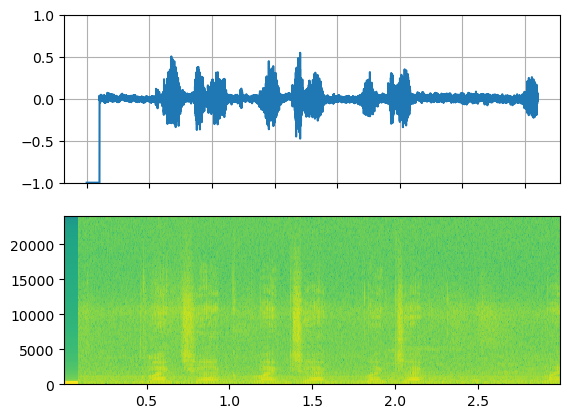

In [17]:
def _display(i):
    print("filter_desc:", streamer.get_out_stream_info(i).filter_description)
    _, axs = plt.subplots(2, 1)
    waveform = chunks[i][:, 0]
    axs[0].plot(waveform)
    axs[0].grid(True)
    axs[0].set_ylim([-1, 1])
    plt.setp(axs[0].get_xticklabels(), visible=False)
    axs[1].specgram(waveform, Fs=out_sample_rate)
    return IPython.display.Audio(chunks[i].T, rate=out_sample_rate)

_display(0)

In [40]:
chunks[0][:,:].size()

torch.Size([144000, 2])

# Slicing the realtime data

In [100]:
out_sample_rate=48000
def disp_waveform(waveform):
    _, axs = plt.subplots(2, 1)
    axs[0].plot(waveform)
    axs[0].grid(True)
    axs[0].set_ylim([-1, 1])
    plt.setp(axs[0].get_xticklabels(), visible=False)
    axs[1].specgram(waveform, Fs=out_sample_rate)
    return IPython.display.Audio(waveform.T, rate=out_sample_rate)

72000
72480
torch.Size([480, 2])
torch.Size([1536, 2])
72480
72960
torch.Size([480, 2])
torch.Size([1536, 2])
72960
73440
torch.Size([480, 2])
torch.Size([1536, 2])
73440
73920
torch.Size([480, 2])
torch.Size([1536, 2])
73920
74400
torch.Size([480, 2])
torch.Size([1536, 2])
74400
74880
torch.Size([480, 2])
torch.Size([1536, 2])


/tmp/ipykernel_16209/2456281244.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  return IPython.display.Audio(waveform.T, rate=out_sample_rate)


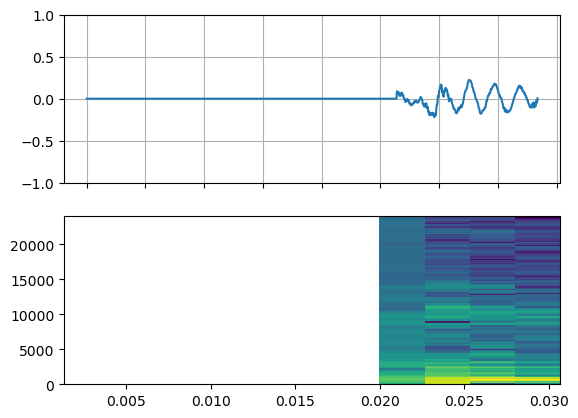

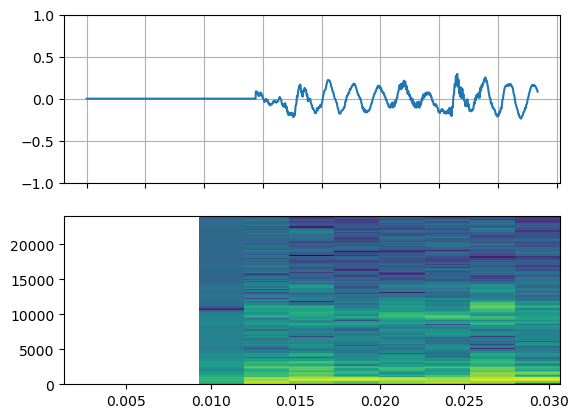

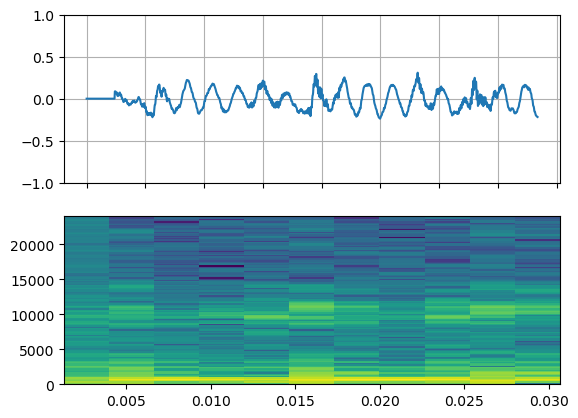

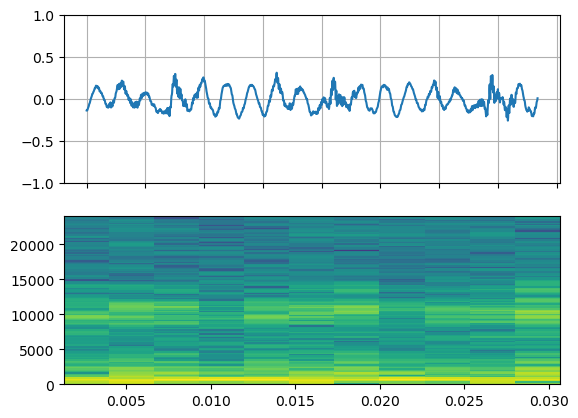

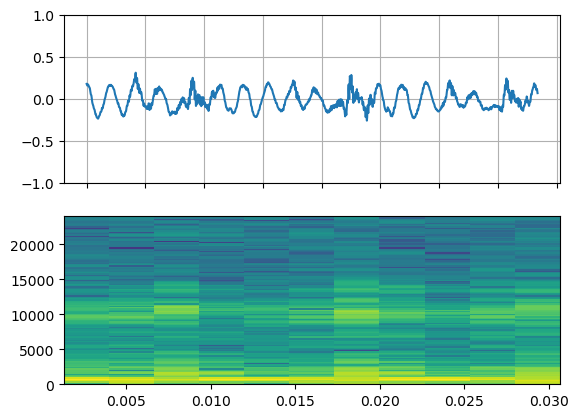

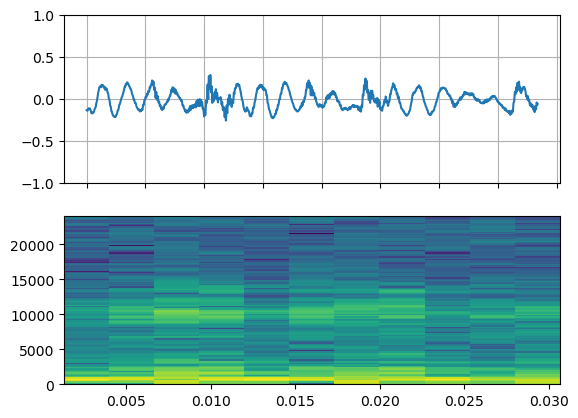

In [101]:
hop_length = 480
frame_length = 1536

# hop_length = 3
# frame_length = 10
n_channels = 2
chan = 0

hop_segment = torch.zeros([hop_length])
frame_segment = torch.zeros([frame_length, n_channels])

for ii in range(150,156,1):
    hop_start_i = ii*hop_length
    hop_end_i = (ii+1)*hop_length
    print(hop_start_i)
    print(hop_end_i)
    hop_segment = chunks[0][hop_start_i:hop_end_i,:]
    print(hop_segment.size())
    
    
    frame_segment = torch.roll(frame_segment,-hop_length,0)
    frame_segment[-hop_length:,:] = hop_segment
    print(frame_segment.size())
    disp_waveform(frame_segment[:,chan])

# CUDA

In [8]:
torch.cuda.is_available()

True

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.index)

None


# ROS audio

In [13]:
data = [137, 3, 112, 3, 56, 3, 0, 3, 233, 2, 189, 2, 179, 2, 190, 2, 99, 2, 44, 2, 50, 2, 26, 2, 24, 2, 15, 2, 41, 2, 91, 2, 133, 2, 199, 2, 241, 2, 43, 3, 57, 3, 69, 3, 110, 3, 69, 3, 254, 2, 191, 2, 146, 2, 101, 2, 50, 2, 30, 2, 210, 1, 159, 1, 164, 1, 148, 1, 214, 1, 43, 2, 99, 2, 165, 2, 223, 2, 21, 3, 82, 3, 123, 3, 123, 3, 119, 3, 126, 3, 119, 3, 98, 3, 90, 3, 39, 3, 183, 2, 71, 2, 219, 1, 144, 1, 120, 1, 98, 1, 69, 1, 39, 1, 0, 1, 1, 1, 25, 1, 28, 1, 67, 1, 89, 1, 87, 1, 120, 1, 130, 1, 79, 1, 45, 1, 21, 1, 226, 0, 179, 0, 119, 0, 124, 0, 135, 0, 83, 0, 66, 0, 65, 0, 66, 0, 84, 0, 39, 0, 235, 255, 221, 255, 186, 255, 174, 255, 170, 255, 144, 255, 160, 255, 128, 255, 44, 255, 18, 255, 213, 254, 168, 254, 206, 254, 194, 254, 169, 254, 171, 254, 188, 254, 16, 255, 65, 255, 96, 255, 123, 255, 103, 255, 111, 255, 88, 255, 64, 255, 87, 255, 85, 255, 33, 255, 220, 254, 170, 254, 132, 254, 158, 254, 216, 254, 178, 254, 134, 254, 128, 254, 117, 254, 143, 254, 173, 254, 210, 254, 238, 254, 3, 255, 51, 255, 66, 255, 106, 255, 176, 255, 183, 255, 186, 255, 211, 255, 239, 255, 17, 0, 60, 0, 102, 0, 85, 0, 57, 0, 64, 0, 104, 0, 170, 0, 205, 0, 214, 0, 236, 0, 5, 1, 13, 1, 17, 1, 48, 1, 46, 1, 253, 0, 196, 0, 168, 0, 196, 0, 208, 0, 194, 0, 165, 0, 122, 0, 83, 0, 28, 0, 231, 255, 162, 255, 116, 255, 108, 255]

In [19]:
librosa.util.buf_to_float(np.asarray(data,dtype=np.uint8), n_bytes=2)
hop = torch.from_numpy(librosa.util.buf_to_float(np.asarray(data,dtype=np.uint8), n_bytes=2))
print(hop.shape)

torch.Size([160])


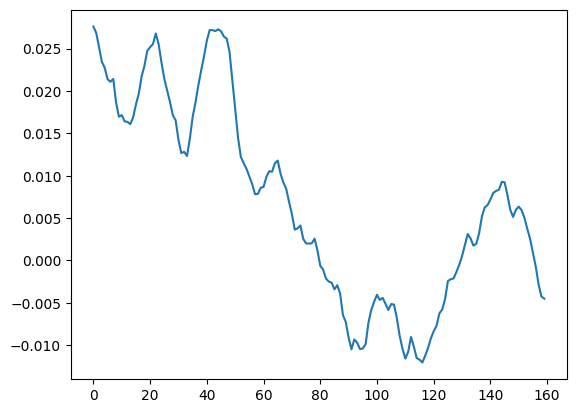

In [20]:
plt.plot(hop)

In [60]:
frame = torch.Tensor([[ 0.0201,  0.0205,  0.0197,  0.0184,  0.0169,  0.0137,  0.0121,  0.0111,
          0.0086,  0.0054,  0.0020,  0.0004, -0.0016, -0.0038, -0.0048, -0.0046,
         -0.0023,  0.0003,  0.0032,  0.0072,  0.0111,  0.0159,  0.0212,  0.0253,
          0.0289,  0.0303,  0.0302,  0.0296,  0.0271,  0.0249,  0.0233,  0.0211,
          0.0188,  0.0169,  0.0141,  0.0111,  0.0103,  0.0103,  0.0088,  0.0070,
          0.0052,  0.0020, -0.0030, -0.0081, -0.0133, -0.0192, -0.0227, -0.0254,
         -0.0280, -0.0273, -0.0248, -0.0215, -0.0171, -0.0125, -0.0082, -0.0044,
         -0.0007,  0.0015,  0.0011, -0.0004, -0.0021, -0.0035, -0.0055, -0.0087,
         -0.0125, -0.0145, -0.0168, -0.0210, -0.0232, -0.0239, -0.0246, -0.0240,
         -0.0226, -0.0200, -0.0164, -0.0119, -0.0052,  0.0018,  0.0084,  0.0148,
          0.0186,  0.0210,  0.0222,  0.0229,  0.0227,  0.0203,  0.0175,  0.0136,
          0.0098,  0.0074,  0.0044,  0.0018, -0.0017, -0.0062, -0.0075, -0.0076,
         -0.0073, -0.0075, -0.0082, -0.0059, -0.0024,  0.0015,  0.0047,  0.0092,
          0.0142,  0.0145,  0.0154,  0.0176,  0.0174,  0.0180,  0.0183,  0.0167,
          0.0140,  0.0133,  0.0139,  0.0113,  0.0098,  0.0103,  0.0101,  0.0110,
          0.0126,  0.0148,  0.0169,  0.0190,  0.0205,  0.0207,  0.0212,  0.0198,
          0.0188,  0.0178,  0.0149,  0.0139,  0.0135,  0.0137,  0.0134,  0.0117,
          0.0108,  0.0096,  0.0093,  0.0096,  0.0083,  0.0064,  0.0057,  0.0061,
          0.0053,  0.0053,  0.0073,  0.0081,  0.0088,  0.0099,  0.0105,  0.0112,
          0.0126,  0.0159,  0.0169,  0.0172,  0.0189,  0.0185,  0.0177,  0.0161,
          0.0143,  0.0121,  0.0092,  0.0087,  0.0075,  0.0057,  0.0060,  0.0078,
          0.0101,  0.0111,  0.0123,  0.0150,  0.0169,  0.0185,  0.0203,  0.0208,
          0.0204,  0.0202,  0.0206,  0.0192,  0.0168,  0.0147,  0.0115,  0.0084,
          0.0051,  0.0027,  0.0002, -0.0026, -0.0032, -0.0033, -0.0027,  0.0003,
          0.0049,  0.0091,  0.0125,  0.0170,  0.0207,  0.0234,  0.0266,  0.0275,
          0.0285,  0.0300,  0.0291,  0.0281,  0.0274,  0.0260,  0.0251,  0.0239,
          0.0222,  0.0214,  0.0205,  0.0199,  0.0197,  0.0174,  0.0133,  0.0102,
          0.0061, -0.0009, -0.0089, -0.0156, -0.0203, -0.0234, -0.0249, -0.0232,
         -0.0201, -0.0148, -0.0080, -0.0028,  0.0018,  0.0065,  0.0097,  0.0093,
          0.0069,  0.0052,  0.0029,  0.0007, -0.0020, -0.0061, -0.0093, -0.0114,
         -0.0130, -0.0139, -0.0147, -0.0168, -0.0190, -0.0196, -0.0194, -0.0182,
         -0.0139, -0.0072, -0.0005,  0.0062,  0.0128,  0.0186,  0.0231,  0.0256,
          0.0261,  0.0241,  0.0213,  0.0181,  0.0131,  0.0083,  0.0032, -0.0020,
         -0.0057, -0.0087, -0.0119, -0.0153, -0.0172, -0.0172, -0.0173, -0.0173,
         -0.0157, -0.0119, -0.0068, -0.0022,  0.0022,  0.0074,  0.0128,  0.0158,
          0.0180,  0.0201,  0.0202,  0.0193,  0.0183,  0.0175,  0.0164,  0.0139,
          0.0126,  0.0107,  0.0078,  0.0066,  0.0059,  0.0058,  0.0069,  0.0093,
          0.0120,  0.0147,  0.0168,  0.0186,  0.0200,  0.0203,  0.0201,  0.0182,
          0.0163,  0.0157,  0.0152,  0.0146,  0.0134,  0.0110,  0.0097,  0.0096,
          0.0096,  0.0081,  0.0055,  0.0040,  0.0036,  0.0037,  0.0039,  0.0043,
          0.0049,  0.0066,  0.0091,  0.0106,  0.0129,  0.0159,  0.0172,  0.0187,
          0.0209,  0.0219,  0.0223,  0.0218,  0.0200,  0.0171,  0.0142,  0.0117,
          0.0097,  0.0082,  0.0069,  0.0069,  0.0086,  0.0103,  0.0121,  0.0157,
          0.0192,  0.0216,  0.0239,  0.0260,  0.0283,  0.0295,  0.0298,  0.0296,
          0.0280,  0.0254,  0.0222,  0.0199,  0.0179,  0.0155,  0.0135,  0.0118,
          0.0111,  0.0105,  0.0105,  0.0104,  0.0103,  0.0133,  0.0169,  0.0194,
          0.0224,  0.0267,  0.0304,  0.0321,  0.0347,  0.0361,  0.0349,  0.0344,
          0.0329,  0.0306,  0.0289,  0.0267,  0.0242,  0.0219,  0.0209,  0.0182,
          0.0155,  0.0153,  0.0155,  0.0149,  0.0133,  0.0114,  0.0093,  0.0056,
         -0.0007, -0.0081, -0.0143, -0.0185, -0.0219, -0.0242, -0.0245, -0.0221,
         -0.0181, -0.0138, -0.0096, -0.0050, -0.0015,  0.0002,  0.0009,  0.0005,
          0.0003, -0.0009, -0.0016, -0.0025, -0.0058, -0.0086, -0.0104, -0.0123,
         -0.0157, -0.0197, -0.0226, -0.0254, -0.0267, -0.0264, -0.0253, -0.0230,
         -0.0182, -0.0114, -0.0054,  0.0012,  0.0084,  0.0138,  0.0172,  0.0182,
          0.0177,  0.0173,  0.0159,  0.0134,  0.0099,  0.0056,  0.0013, -0.0024,
         -0.0056, -0.0107, -0.0163, -0.0204, -0.0230, -0.0244, -0.0246, -0.0229,
         -0.0199, -0.0168, -0.0129, -0.0087, -0.0042, -0.0003,  0.0030,  0.0053,
          0.0055,  0.0070,  0.0096,  0.0105,  0.0110,  0.0113,  0.0119,  0.0113,
          0.0094,  0.0085,  0.0074,  0.0055,  0.0059,  0.0073,  0.0081,  0.0100,
          0.0124,  0.0132,  0.0135,  0.0141,  0.0145,  0.0158,  0.0169,  0.0164,
          0.0160,  0.0157,  0.0154,  0.0157,  0.0162,  0.0166,  0.0167,  0.0165,
          0.0161,  0.0148,  0.0130,  0.0116,  0.0106,  0.0098,  0.0089,  0.0079,
          0.0085,  0.0096,  0.0107,  0.0121,  0.0152,  0.0191,  0.0215,  0.0245,
          0.0270,  0.0270,  0.0265,  0.0260,  0.0242,  0.0215,  0.0189,  0.0170,
          0.0151,  0.0134,  0.0130,  0.0131,  0.0141,  0.0170,  0.0201,  0.0225,
          0.0255,  0.0284,  0.0297,  0.0308,  0.0314,  0.0309,  0.0297,  0.0280,
          0.0256,  0.0228,  0.0201,  0.0177,  0.0156,  0.0139,  0.0123,  0.0108,
          0.0106,  0.0106,  0.0107,  0.0117,  0.0122,  0.0143,  0.0186,  0.0229,
          0.0271,  0.0309,  0.0350,  0.0378,  0.0378,  0.0380,  0.0385,  0.0376,
          0.0359,  0.0337,  0.0308,  0.0287,  0.0277,  0.0266,  0.0245,  0.0229,
          0.0224,  0.0203,  0.0168,  0.0135,  0.0093,  0.0028, -0.0056, -0.0138,
         -0.0203, -0.0261, -0.0311, -0.0331, -0.0318, -0.0285, -0.0240, -0.0190,
         -0.0142, -0.0094, -0.0048, -0.0020, -0.0012, -0.0016, -0.0022, -0.0033,
         -0.0040, -0.0045, -0.0060, -0.0080, -0.0102, -0.0127, -0.0161, -0.0202,
         -0.0221, -0.0228, -0.0229, -0.0225, -0.0204, -0.0155, -0.0096, -0.0028,
          0.0038,  0.0106,  0.0169,  0.0212,  0.0235,  0.0246,  0.0238,  0.0232,
          0.0219,  0.0172,  0.0128,  0.0098,  0.0060,  0.0015, -0.0027, -0.0076,
         -0.0103, -0.0113, -0.0129, -0.0144, -0.0151, -0.0140, -0.0118, -0.0059,
          0.0015,  0.0065,  0.0106,  0.0144,  0.0164,  0.0172,  0.0178,  0.0181,
          0.0177,  0.0157,  0.0137,  0.0121,  0.0099,  0.0077,  0.0067,  0.0056,
          0.0045,  0.0052,  0.0069,  0.0103,  0.0126,  0.0134,  0.0157,  0.0177,
          0.0194,  0.0204,  0.0203,  0.0205,  0.0193,  0.0184,  0.0182,  0.0173,
          0.0167,  0.0150,  0.0116,  0.0093,  0.0087,  0.0083,  0.0072,  0.0063,
          0.0059,  0.0053,  0.0057,  0.0067,  0.0067,  0.0071,  0.0085,  0.0101,
          0.0110,  0.0121,  0.0139,  0.0155,  0.0169,  0.0186,  0.0199,  0.0201,
          0.0198,  0.0186,  0.0147,  0.0097,  0.0062,  0.0038,  0.0024,  0.0018,
          0.0013,  0.0022,  0.0040,  0.0063,  0.0086,  0.0107,  0.0133,  0.0158,
          0.0177,  0.0189,  0.0196,  0.0197,  0.0201,  0.0201,  0.0184,  0.0171,
          0.0152,  0.0121,  0.0096,  0.0074,  0.0056,  0.0037,  0.0013,  0.0005,
          0.0005,  0.0002,  0.0018,  0.0034,  0.0042,  0.0071,  0.0111,  0.0151,
          0.0203,  0.0244,  0.0274,  0.0291,  0.0292,  0.0297,  0.0277,  0.0254,
          0.0236,  0.0207,  0.0184,  0.0171,  0.0173,  0.0190,  0.0193,  0.0194,
          0.0180,  0.0151,  0.0103,  0.0034, -0.0041, -0.0130, -0.0197, -0.0240,
         -0.0284, -0.0285, -0.0251, -0.0211, -0.0167, -0.0113, -0.0071, -0.0041,
         -0.0004,  0.0020,  0.0027,  0.0025,  0.0034,  0.0031,  0.0011,  0.0008,
          0.0002, -0.0002, -0.0008, -0.0040, -0.0070, -0.0110, -0.0154, -0.0176,
         -0.0198, -0.0206, -0.0171, -0.0110, -0.0036,  0.0042,  0.0116,  0.0191,
          0.0252,  0.0295,  0.0323,  0.0329,  0.0314,  0.0285,  0.0248,  0.0201,
          0.0151,  0.0119,  0.0085,  0.0039, -0.0003, -0.0042, -0.0074, -0.0091,
         -0.0095, -0.0091, -0.0080, -0.0053, -0.0015,  0.0032,  0.0085,  0.0132]])

# Feature extraction

In [62]:
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

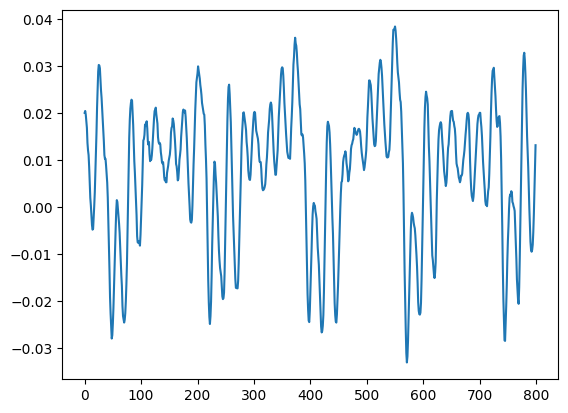

In [68]:
plt.plot(frame[0,:])

torch.Size([1, 800])


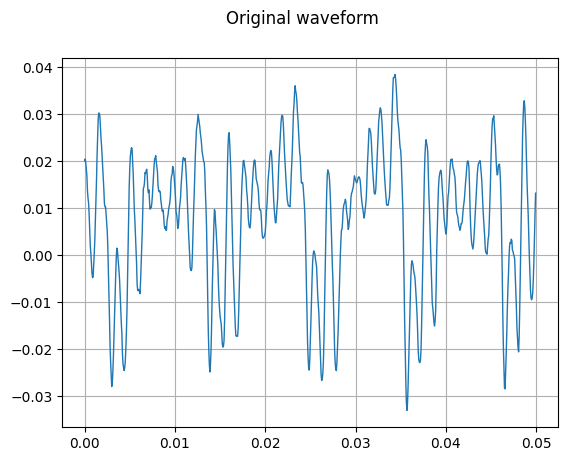

In [69]:
print(frame.shape)

plot_waveform(frame, 16000, title="Original waveform")
Audio(frame.numpy(), rate=16000)

## Zero crossing rate

In [104]:
# librosa.feature.zero_crossing_rate(frame.numpy().T, frame_length=800, hop_length=1, center=False)

small_frame = frame[:,:20]
print(small_frame)
print(small_frame>0)
torch.sum(torch.diff(small_frame > 0),1)/small_frame.size(1)

tensor([[ 0.0201,  0.0205,  0.0197,  0.0184,  0.0169,  0.0137,  0.0121,  0.0111,
          0.0086,  0.0054,  0.0020,  0.0004, -0.0016, -0.0038, -0.0048, -0.0046,
         -0.0023,  0.0003,  0.0032,  0.0072]])
tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True, False, False, False, False, False,  True,  True,  True]])


tensor([0.1000])

# RMS energy

In [110]:
small_frame = frame[:,:20]
print(small_frame)
print(torch.square(small_frame))
print(torch.sum(torch.square(small_frame)))
print(torch.sum(torch.square(small_frame))/20)
print(torch.sqrt(torch.sum(torch.square(small_frame))/20))

tensor([[ 0.0201,  0.0205,  0.0197,  0.0184,  0.0169,  0.0137,  0.0121,  0.0111,
          0.0086,  0.0054,  0.0020,  0.0004, -0.0016, -0.0038, -0.0048, -0.0046,
         -0.0023,  0.0003,  0.0032,  0.0072]])
tensor([[4.0401e-04, 4.2025e-04, 3.8809e-04, 3.3856e-04, 2.8561e-04, 1.8769e-04,
         1.4641e-04, 1.2321e-04, 7.3960e-05, 2.9160e-05, 4.0000e-06, 1.6000e-07,
         2.5600e-06, 1.4440e-05, 2.3040e-05, 2.1160e-05, 5.2900e-06, 9.0000e-08,
         1.0240e-05, 5.1840e-05]])
tensor(0.0025)
tensor(0.0001)
tensor(0.0112)


## MFCC

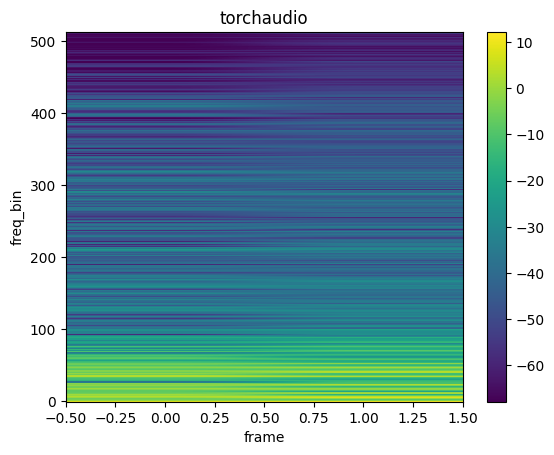

In [66]:
n_fft = 1024
win_length = None
hop_length = 512

# Define transform
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

spec = spectrogram(frame)
plot_spectrogram(spec[0], title="torchaudio")